In [2]:
# !unzip img_cls_weather_dataset.zip

In [3]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
# fixed random values
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

#### Read Data

In [5]:
root_dir = 'weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(sorted(os.listdir(root_dir)))
}

# read all folder path contains labels match with data
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

#### Train - Val - Test Split

In [6]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

#### Build Class Dataset


In [7]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [8]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img

In [9]:
train_dataset = WeatherDataset(X_train, y_train, transform=transform)
val_dataset = WeatherDataset(X_val, y_val, transform=transform)
test_dataset = WeatherDataset(X_test, y_test, transform=transform)

In [10]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

#### Build ResNet Model

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

In [12]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for _ in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)

        block_seq = nn.Sequential(*blocks)
        return block_seq

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [13]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

cuda


#### Create Model Evaluate Function

In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    loss = sum(losses) / len(losses)
    return accuracy, loss

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_accuracy, val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:\tTrain Loss: {train_loss:.4f}\tVal Loss: {val_loss:.4f}\tVal Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses

In [16]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, device, epochs)

Epoch 1/25:	Train Loss: 1.8799	Val Loss: 2.3848	Val Accuracy: 18.14%
Epoch 2/25:	Train Loss: 1.2874	Val Loss: 2.3704	Val Accuracy: 21.92%
Epoch 3/25:	Train Loss: 1.0117	Val Loss: 2.1507	Val Accuracy: 31.68%
Epoch 4/25:	Train Loss: 0.8008	Val Loss: 1.6003	Val Accuracy: 52.08%
Epoch 5/25:	Train Loss: 0.6580	Val Loss: 1.1334	Val Accuracy: 62.78%
Epoch 6/25:	Train Loss: 0.5078	Val Loss: 1.0893	Val Accuracy: 62.49%
Epoch 7/25:	Train Loss: 0.3821	Val Loss: 1.1931	Val Accuracy: 61.11%
Epoch 8/25:	Train Loss: 0.3258	Val Loss: 1.1262	Val Accuracy: 63.22%
Epoch 9/25:	Train Loss: 0.2237	Val Loss: 1.0009	Val Accuracy: 67.95%
Epoch 10/25:	Train Loss: 0.1527	Val Loss: 1.0027	Val Accuracy: 65.26%
Epoch 11/25:	Train Loss: 0.1144	Val Loss: 0.9242	Val Accuracy: 69.41%
Epoch 12/25:	Train Loss: 0.0934	Val Loss: 0.9458	Val Accuracy: 68.61%
Epoch 13/25:	Train Loss: 0.0717	Val Loss: 0.9031	Val Accuracy: 69.99%
Epoch 14/25:	Train Loss: 0.0556	Val Loss: 0.9489	Val Accuracy: 69.41%
Epoch 15/25:	Train Loss: 0.04

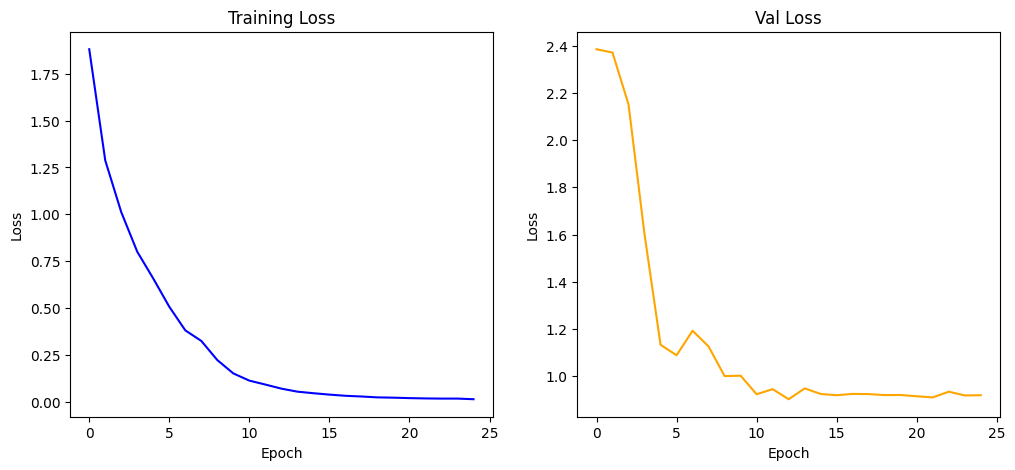

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses, color='blue')
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [18]:
# Model Evaluation
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.9200092175715539
Test accuracy: 0.9836651543371899
